# General information

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.
В данной части будет выполнен разведывательный анализ данных и составлен отчет.

In [1]:
# libraries
from scipy.stats import ttest_ind
from itertools import combinations
import pandas as pd
import matplotlib
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Data overview

In [2]:
stud_math = pd.read_csv('stud_math.csv')
stud_math.info()
stud_math.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


В наборе данных содержится 395 строк и 30 столбцов.
Данные можно разделить на:

In [3]:
numerical_columns = ['age', 'absences', 'score']
binary_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
                  'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
categorial_columns = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
                      'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health']

Информация о колонке 'studytime, granular' отсутствует. Посмотрим на ее корреляцию:

In [4]:
stud_math.corr()['studytime, granular'].sort_values()

studytime             -1.000000
score                 -0.115741
Medu                  -0.078589
Fedu                  -0.057199
famrel                -0.045894
age                    0.015556
absences               0.026544
goout                  0.051280
health                 0.080016
traveltime             0.102206
freetime               0.121969
failures               0.178992
studytime, granular    1.000000
Name: studytime, granular, dtype: float64

ее данные коррелируют с колонкой 'studytime'. Поэтому удалим ее

In [5]:
stud_math.drop(['studytime, granular'], inplace=True, axis=1)

Посмотрим на количество пропущенных значений:

In [6]:
stud_math.isnull().sum()

school         0
sex            0
age            0
address       17
famsize       27
Pstatus       45
Medu           3
Fedu          24
Mjob          19
Fjob          36
reason        17
guardian      31
traveltime    28
studytime      7
failures      22
schoolsup      9
famsup        39
paid          40
activities    14
nursery       16
higher        20
internet      34
romantic      31
famrel        27
freetime      11
goout          8
health        15
absences      12
score          6
dtype: int64

Только первые 3 колонки (школа, возраст и пол) не содержат пропущенных значений.

# Data preparation

In [7]:
def numeric_view(col):
    """ 
    Функция описывает числовую переменную
    """
    print(stud_math[col].describe())
    b = stud_math[col].isnull().sum()
    print(f'В колонке пропущнных значений: {b}')

In [8]:
def graf_num(col):
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(12, 6)
    )

    ax1.hist(stud_math[col], bins=77)
    ax1.set_title(f'Гистограмма {col}')
    ax1.set_xlabel(f'значения {col}')
    ax1.set_ylabel('количество значений')

    sns.swarmplot(x=col, y='score', data=stud_math, ax=ax2)

    ax2.set_title(f'Зависимость баллов от {col}')
    ax2.set_xlabel(f'значения {col}')
    ax2.set_ylabel('баллы')

    plt.show

In [9]:
def categorial_view(col):
    """ 
    Функция описывает категориальную переменную
    """
    a = stud_math[col].isnull().sum()

    print(f'В колонке уникальных значений: {stud_math[col].nunique()}')
    print(f'В колонке пропущнных значений: {a}')
    print(stud_math[col].describe())
    print('Распределение значений в %:')
    print(pd.DataFrame(stud_math[col].value_counts(1)))
    print('Средние значения баллов по значениям:')
    # если брать в рассмотрение ноль баллов, то это не меняет картины, но ноль баллов не отражает знания
    print(stud_math[stud_math.score >= 20].groupby(col)['score'].mean())

In [10]:
def graf_cat(col):
    fig, (ax1, ax2, ax) = plt.subplots(
        nrows=1, ncols=3,
        figsize=(12, 6)
    )

    ax1.hist(stud_math[col])
    ax1.set_title(f'Гистограмма {col}')
    ax1.set_xlabel(f'значения {col}')
    ax1.set_ylabel('количество значений')

    sns.boxplot(col, "score", data=stud_math, ax=ax2)

    ax2.set_title(f'Зависимость баллов от {col}')
    ax2.set_xlabel(f'значения {col}')
    ax2.set_ylabel('баллы')

    sns.swarmplot(col, "score", data=stud_math, ax=ax)

    ax.set_title(f'Зависимость баллов от {col}')
    ax.set_xlabel(f'значения {col}')
    ax.set_ylabel('баллы')

    plt.show()

In [11]:
def outliers(column):
    outlier1 = outlier2 = 0
    """ 
    Функция проверяет наличие выбросов через межквартильный размах
    """
    q1 = stud_math[column].quantile(q=0.25, interpolation='midpoint')
    q3 = stud_math[column].quantile(q=0.75, interpolation='midpoint')
    MR = round(q3 - q1, 1)
    limit1 = q1 - 1.5 * MR
    limit2 = q3 + 1.5 * MR
    if stud_math[column].min() < limit1:
        print(f'выбросы ниже {limit1}')
    elif stud_math[column].max() > limit2:
        print(f'выбросы выше {limit2}')
    else:
        print('выбросов нет')
    return

In [12]:
def replace_mode(col):
    stud_math.loc[:, col] = stud_math.loc[:, col].astype(
        str).apply(lambda x: None if x.strip() == '' else x)
    mode_col = stud_math.loc[:, col].mode()
    stud_math.loc[:, col] = stud_math.loc[:, col].apply(
        lambda x: x.replace('nan', mode_col[0]))

In [13]:
def graf_no(col):
    """ 
    Функция строит вероятность получить 0 баллов
    """
    age = pd.DataFrame()
    age['all'] = stud_math.groupby(col)['score'].count()
    age['NO'] = stud_math[stud_math.score == 0].groupby([col]).interest.count()
    age['ratio'] = age['NO'] * 100 / age['all']
    age.ratio.plot(kind='bar', title='вероятность в % получить 0 баллов')

In [14]:
def get_stat_dif(column):
    """ 
    Функция проверяет статистически значимые различия колонок
    """
    cols = stud_math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Data Exploration

#### Так как основной показатель успеваемости по математике - это  баллы по госэкзамену, то с них и начнем
# score

In [15]:
numeric_view('score')

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64
В колонке пропущнных значений: 6


Минимальное 0, максимальное 100 - выбросов нет. Посмотрим поближе на пропуски

In [16]:
stud_math[stud_math.score.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,NaN,yes,yes,yes,no,no,4.0,NaN,3.0,4.0,6.0,NaN
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,NaN,4.0,4.0,4.0,NaN
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,yes,yes,no,4.0,5.0,NaN,4.0,3.0,NaN
350,MS,M,19,NaN,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,NaN,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN


В даной выборке больше девушек, но есть и парни (ниже показано процентное соотношение во всем датасете), что в целом отражает весь набор данных. Группа школьников с диапазоне 16-19 лет (показано ниже) содержит достаточно значимое количество наблюдений (тогда как в возрасте 20-22 года - от 1 до 3 человек).
С учетом этого и, так как большая часть признаков имеет различные значения от ученика к ученику, это позволяет удалить данные без значимого изменения результатов

In [17]:
stud_math = stud_math.loc[stud_math.score.notnull()]

Text(0, 0.5, 'количество значений')

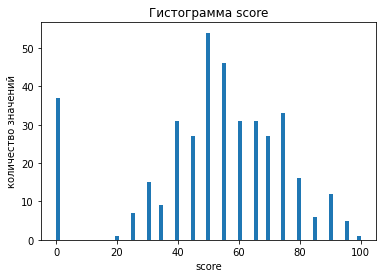

In [18]:
fig, (ax1) = plt.subplots(
    nrows=1, ncols=1,
)

ax1.hist(stud_math['score'], bins=77)
ax1.set_title('Гистограмма score')
ax1.set_xlabel('score')
ax1.set_ylabel('количество значений')

Данные баллов за госэкзамен по математике представляют распределение  со смещением вправо при максимуме около 50 баллов.
Анализируя гистограмму, можно предположить, что ученики, у которых стоит 0 баллов получили их за отсутствие на экзамене или не выполняли задания вовсе по другой причине,что не отражает знания по математике. иначе диапазон до 20 баллов был бы заполнен. На этом основании их результат не будем брать в рассмотрение  при анализе баллов.
Введем новый бинарный признак interest, предположив что школьники могут разочароваться в математике или не пойти на экзамен(значение NO)

In [19]:
stud_math['interest'] = stud_math.apply(
    lambda x: 'YES' if x.score >= 20 else 'NO', axis=1)

In [20]:
print(f'таких учеников - {len(stud_math[stud_math["interest"] == "NO"])} ')

таких учеников - 37 


# age
#### возраст ученика (от 15 до 22)

In [21]:
numeric_view('age')

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
В колонке пропущнных значений: 0


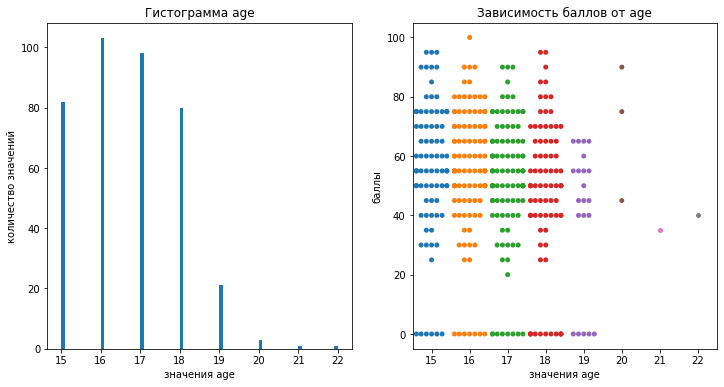

In [22]:
graf_num('age')

Этот столбец числовой и без пропусков. Все значения в пределах заявленного возраста от 15 до 22. Однако для для 19-22 лет мало наблюдений

И оценим средние значения баллов в зависимости от возраста:

In [23]:
stud_math[stud_math.score >= 20].groupby('age')['score'].mean()

age
15    60.723684
16    59.218750
17    55.944444
18    56.014493
19    52.812500
20    70.000000
21    35.000000
22    40.000000
Name: score, dtype: float64

Посмотрим как соотносятся полученные 0 баллов с возрастом:

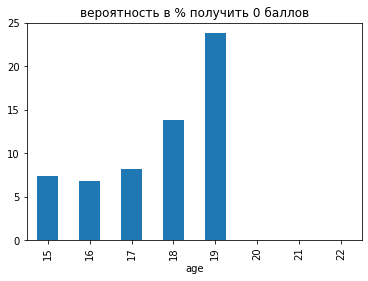

In [24]:
graf_no('age')

Заметен тренд на уменьшение среднего значения баллов по математике с увеличением возраста от 15 лет до 19 лет с одновременным ростом вероятности получить 0 баллов (не сдавать). В 20 лет  присутствуют всего 3 наблюдения, а  среднее значениие заметно выше и начиная с этого востаста все обучающиеся сдавали экзамен. В 21-22 год всего по одному значению, что в целом не позволяет делать однозначные выводы об успеваемости.
В целом данный признак больше влияет на получение 0 баллов, чем отражает результаты по математике

# absences
  #### количество пропущенных занятий
Посмотрим на пропущенны значения:

In [25]:
stud_math[stud_math.absences.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
24,GP,F,15,R,GT3,T,2.0,4.0,services,health,course,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,NaN,40.0,YES
101,GP,M,16,U,GT3,T,4.0,4.0,services,teacher,other,father,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0,YES
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0,YES
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0,YES
150,GP,M,18,U,LE3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,yes,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0,NO
172,GP,M,17,U,NaN,T,4.0,4.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,4.0,5.0,NaN,50.0,YES
215,GP,F,17,U,LE3,T,3.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,no,NaN,no,yes,yes,NaN,no,4.0,4.0,4.0,1.0,NaN,75.0,YES
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0,YES
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0,YES
265,GP,M,18,R,LE3,NaN,3.0,4.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0,YES


Каких-то особенностей по связи пропусков не найдено, поэтому заменим на наиболее частое и вернем тип столбца к числовому

In [26]:
replace_mode('absences')
stud_math.absences = stud_math.absences.astype(float)

In [27]:
stud_math['absences'].describe()

count    389.000000
mean       7.113111
std       23.310047
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Максимальное значение в 385 явно свидетельствует о наличии выбросов:

In [28]:
outliers('absences')

выбросы выше 20.0


Посмотрим на параметры пропущенных значений свыше 20:

In [29]:
stud_math[stud_math.absences > 20].absences.sort_values()

260     21.0
313     22.0
277     22.0
216     22.0
320     23.0
198     24.0
40      25.0
103     26.0
205     28.0
280     30.0
307     38.0
315     40.0
74      54.0
183     56.0
276     75.0
390    212.0
222    385.0
Name: absences, dtype: float64

Большая часть значений укладывается в 30 пропущенных занятий, а далее идут большие промежутки. Поэтому ограничим выбросы числом 30

In [30]:
stud_math = stud_math.loc[stud_math.absences.between(0, 30)]

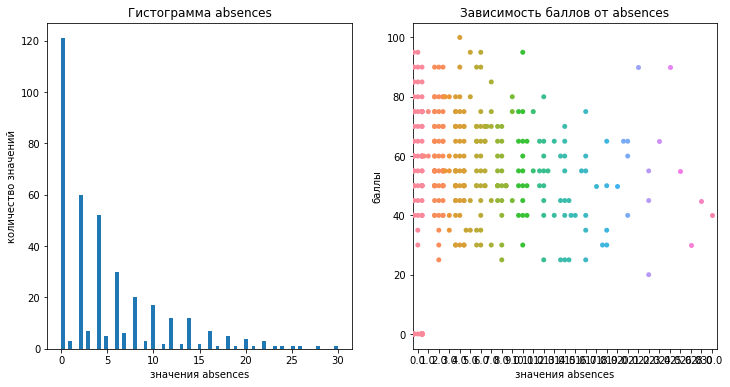

In [31]:
graf_num('absences')

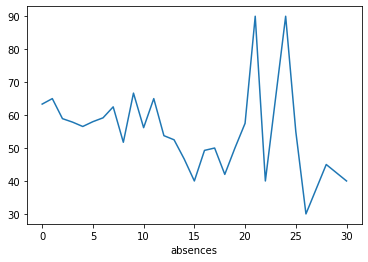

In [32]:
stud_math[stud_math.score >=20].groupby('absences')['score'].mean().plot()

Видно снижение баллов с увеличение пропущенных занятий.Хотя присутствуют наблюдения, когда пропущено больше 20 занятий, но высокий балл и  треть от тех, кто не пропускал занятий получил ноль баллов, что очень занимательно.
Посмотрим на распредение среднего значения баллов по пропускам: не считая двух выбросов происходит планомерное снижение.  

# school

    аббревиатура школы, в которой учится ученик

In [33]:
categorial_view('school')

В колонке уникальных значений: 2
В колонке пропущнных значений: 0
count     382
unique      2
top        GP
freq      338
Name: school, dtype: object
Распределение значений в %:
      school
GP  0.884817
MS  0.115183
Средние значения баллов по значениям:
school
GP    58.311475
MS    54.500000
Name: score, dtype: float64


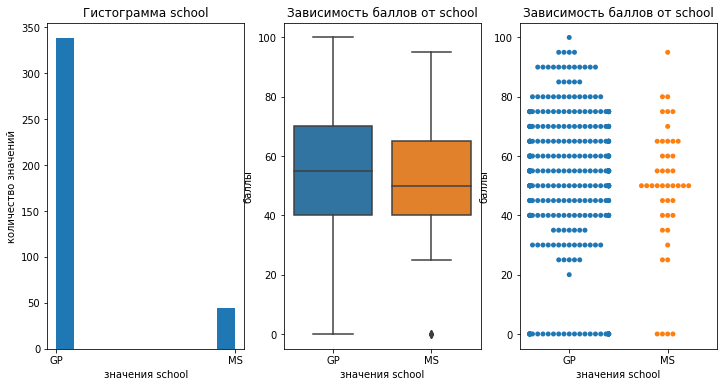

In [34]:
graf_cat('school')

In [35]:
stud_math.groupby('school').interest.value_counts(1)

school  interest
GP      YES         0.902367
        NO          0.097633
MS      YES         0.909091
        NO          0.090909
Name: interest, dtype: float64

В данных содержатся сведения об учениках из двух школ: 88.5% из GP и 11.5% из MS. Средние значения баллов по математике и их распределение в обеих школах отличаются незначительно с учетом разного количества наблюдений
Количество учеников, получивших ноль на экзамене в обеих школах примерно одинаково 9,1 -9,8 %.

# sex

пол ученика ('F' - женский, 'M' - мужской)

In [36]:
categorial_view('sex')

В колонке уникальных значений: 2
В колонке пропущнных значений: 0
count     382
unique      2
top         F
freq      199
Name: sex, dtype: object
Распределение значений в %:
        sex
F  0.520942
M  0.479058
Средние значения баллов по значениям:
sex
F    56.158192
M    59.672619
Name: score, dtype: float64


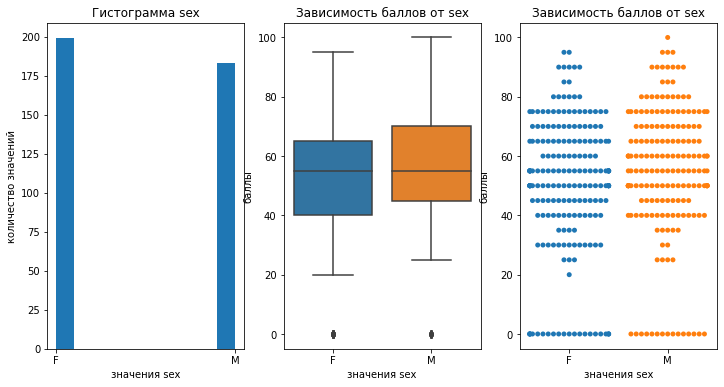

In [37]:
graf_cat('sex')

In [38]:
stud_math.groupby('sex').interest.value_counts(1)

sex  interest
F    YES         0.889447
     NO          0.110553
M    YES         0.918033
     NO          0.081967
Name: interest, dtype: float64

Столбец без пропусков и категориальный. 52,1 % учащихся составляют девушки. Что свидетельствует о нормальной выборке в данных. 
Превышение в баллах по математике парней не превышает 10 %. Исходя из графика распределение баллов довольно равномерное.
11 % девушек получили 0 баллов и 8,2 % парней.

# address 

тип адреса ученика ('U' - городской, 'R' - за городом)

In [39]:
categorial_view('address')

В колонке уникальных значений: 2
В колонке пропущнных значений: 15
count     367
unique      2
top         U
freq      286
Name: address, dtype: object
Распределение значений в %:
    address
U  0.779292
R  0.220708
Средние значения баллов по значениям:
address
R    53.450704
U    58.942308
Name: score, dtype: float64


In [40]:
stud_math[stud_math.address.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0,YES
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0,YES
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0,YES
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0,YES
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0,YES
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0,YES
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0,NO
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0,YES
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,0.0,60.0,YES
292,GP,F,18,NaN,LE3,T,2.0,1.0,services,at_home,reputation,mother,1.0,2.0,1.0,no,NaN,no,no,yes,yes,yes,yes,5.0,4.0,3.0,5.0,12.0,65.0,YES


Посмотрим как соотносится проживание в городе и загородом в зависимости от времени на дорогу:

In [41]:
stud_math.groupby('traveltime').address.value_counts(1)

traveltime  address
1.0         U          0.854626
            R          0.145374
2.0         U          0.712644
            R          0.287356
3.0         R          0.571429
            U          0.428571
4.0         R          0.571429
            U          0.428571
Name: address, dtype: float64

Исходя из этого соотношения большая часть с позициями 1 и 2 - это городские жители. Преобразуем пропуски:

In [42]:
replace_mode('address')

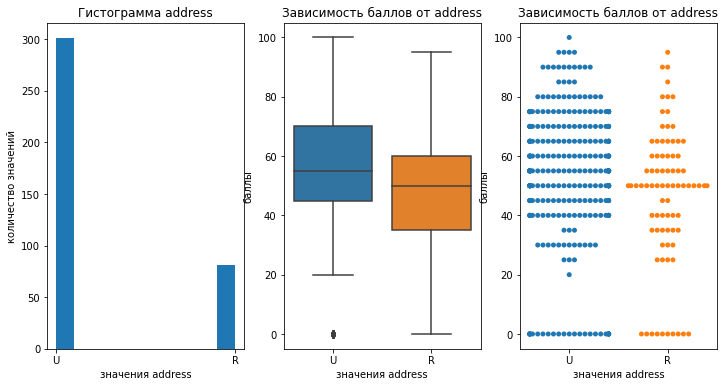

In [43]:
graf_cat('address')

Распределение в % на тех кто сдавал и нет:

In [44]:
stud_math.groupby('address').interest.value_counts(1)

address  interest
R        YES         0.876543
         NO          0.123457
U        YES         0.910299
         NO          0.089701
Name: interest, dtype: float64

Средние значения близки для обоих мест проживания. А вот вероятность что ученик не будет сдавать экзамен за городом выше.

# famsize 
#### размер семьи('LE3' <= 3, 'GT3' >3)

In [45]:
categorial_view('famsize')

В колонке уникальных значений: 2
В колонке пропущнных значений: 27
count     355
unique      2
top       GT3
freq      250
Name: famsize, dtype: object
Распределение значений в %:
      famsize
GT3  0.704225
LE3  0.295775
Средние значения баллов по значениям:
famsize
GT3    57.645740
LE3    58.826531
Name: score, dtype: float64


In [46]:
stud_math[stud_math.famsize.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,YES
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0,YES
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0,YES
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0,YES
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0,YES
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0,YES
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0,YES
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0,YES
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0,NO
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,0.0,90.0,YES


In [47]:
stud_math.groupby('famsize').Mjob.value_counts(1)

famsize  Mjob    
GT3      other       0.362869
         services    0.265823
         at_home     0.160338
         teacher     0.126582
         health      0.084388
LE3      other       0.297030
         services    0.287129
         teacher     0.188119
         at_home     0.128713
         health      0.099010
Name: Mjob, dtype: float64

Распределение в % по работе матери не говорит о размере семьи

In [48]:
stud_math.groupby('famsize').address.value_counts(1)

famsize  address
GT3      U          0.776000
         R          0.224000
LE3      U          0.828571
         R          0.171429
Name: address, dtype: float64

Также как и проживание. Тогда замним пропуски на моду

In [49]:
replace_mode('famsize')

И посмотрим распределение баллов в зависимости от размера семьи:

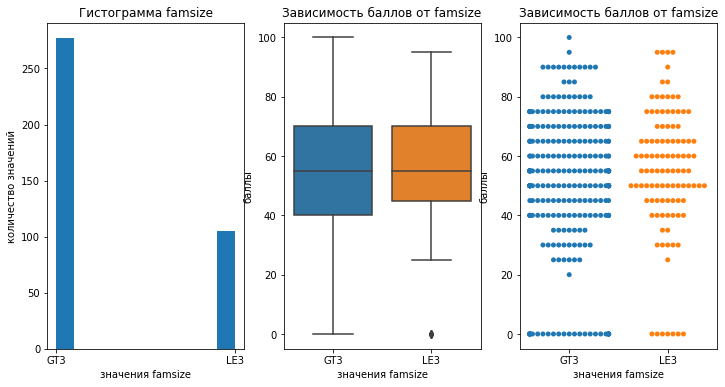

In [50]:
graf_cat('famsize')

In [51]:
stud_math.groupby('famsize').interest.value_counts(1)

famsize  interest
GT3      YES         0.891697
         NO          0.108303
LE3      YES         0.933333
         NO          0.066667
Name: interest, dtype: float64

Распределение баллов похоже для обоих категорий семей. А вот вероятность что ученик не будет сдавать экзамен в большой семье выше.

# Pstatus

#### статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [52]:
categorial_view('Pstatus')

В колонке уникальных значений: 2
В колонке пропущнных значений: 43
count     339
unique      2
top         T
freq      305
Name: Pstatus, dtype: object
Распределение значений в %:
    Pstatus
T  0.899705
A  0.100295
Средние значения баллов по значениям:
Pstatus
A    59.218750
T    57.408759
Name: score, dtype: float64


посмотрим на пропуски

In [53]:
stud_math[stud_math.Pstatus.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,YES
9,GP,M,15,U,GT3,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0,YES
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0,YES
15,GP,F,16,U,GT3,NaN,4.0,4.0,health,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,yes,yes,no,4.0,4.0,4.0,2.0,4.0,70.0,YES
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0,YES
28,GP,M,16,U,LE3,NaN,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0,YES
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0,YES
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0,YES
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0,YES
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0,YES


Может посмотреть есть ли зависимость от размера семьи, проживания и работы матери:

In [54]:
stud_math.groupby('Pstatus').Mjob.value_counts(1)

Pstatus  Mjob    
A        other       0.393939
         services    0.272727
         teacher     0.151515
         at_home     0.090909
         health      0.090909
T        other       0.339041
         services    0.239726
         at_home     0.167808
         teacher     0.157534
         health      0.095890
Name: Mjob, dtype: float64

Преобразуем пропуски и посмотрим на зависимость баллов:

In [55]:
stud_math.groupby('Pstatus').address.value_counts(1)

Pstatus  address
A        U          0.882353
         R          0.117647
T        U          0.770492
         R          0.229508
Name: address, dtype: float64

In [56]:
stud_math.groupby('Pstatus').famsize.value_counts(1)

Pstatus  famsize
A        GT3        0.647059
         LE3        0.352941
T        GT3        0.734426
         LE3        0.265574
Name: famsize, dtype: float64

Так как зависимостей нет, то заменим на моду:

In [57]:
replace_mode('Pstatus')

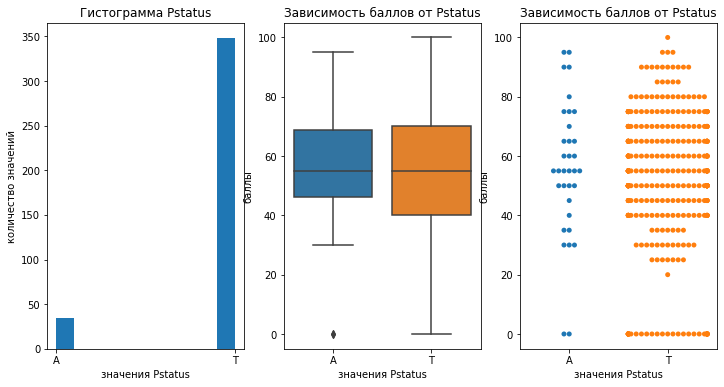

In [58]:
graf_cat('Pstatus')

In [59]:
stud_math.groupby('Pstatus').interest.value_counts(1)

Pstatus  interest
A        YES         0.941176
         NO          0.058824
T        YES         0.899425
         NO          0.100575
Name: interest, dtype: float64

Набранные баллы для обех семей отличаются не сильно. В полной семье дети почти в 2 раза чаще не сдают экзаммен

# образование родителей
 #### 0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее

  ### Medu - матери
  ### Fedu - отца

In [60]:
categorial_view('Medu')

В колонке уникальных значений: 5
В колонке пропущнных значений: 3
count    379.000000
mean       2.767810
std        1.100225
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64
Распределение значений в %:
         Medu
4.0  0.343008
2.0  0.255937
3.0  0.245383
1.0  0.147757
0.0  0.007916
Средние значения баллов по значениям:
Medu
0.0    65.000000
1.0    51.382979
2.0    56.176471
3.0    57.559524
4.0    61.814516
Name: score, dtype: float64


 Отсутствут всего 3 значения - мало для подбора сходств или отличий. Заменим на моду:

In [61]:
replace_mode('Medu')

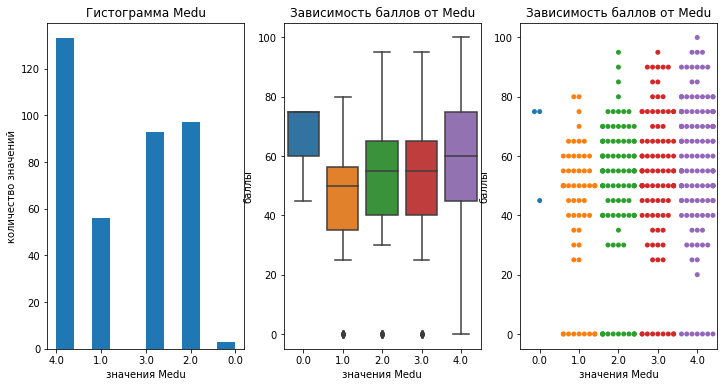

In [62]:
graf_cat('Medu')

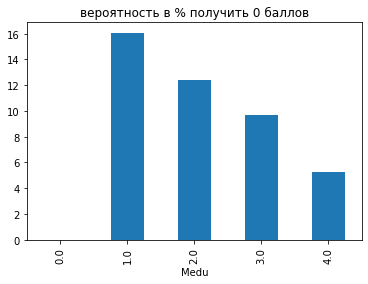

In [63]:
graf_no('Medu')

При повышении уровня образования матери балл растет. Но стоит отметить что для параметра 0 вссего 3 наблюдения. и это выбивается, что скорее всего связано с малым количством наблюдений для данной категории. Вероятность не сдавать экзамен также уменьшается кратно.

In [64]:
categorial_view('Fedu')

В колонке уникальных значений: 6
В колонке пропущнных значений: 24
count    358.000000
mean       2.622905
std        2.261660
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64
Распределение значений в %:
          Fedu
2.0   0.287709
3.0   0.251397
4.0   0.243017
1.0   0.209497
0.0   0.005587
40.0  0.002793
Средние значения баллов по значениям:
Fedu
0.0     65.000000
1.0     53.461538
2.0     58.097826
3.0     57.000000
4.0     61.518987
40.0    60.000000
Name: score, dtype: float64


In [65]:
stud_math[stud_math.Fedu.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0,YES
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0,YES
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0,YES
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0,YES
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0,YES
67,GP,F,16,U,GT3,T,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0,YES
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0,NO
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0,YES
159,GP,M,16,U,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0,YES
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0,YES


Связи с работой отца, образованием, размером семьи или работой матери не наблюдатся, поэтому замним на моду  и вернем числовой формат:

In [66]:
replace_mode('Fedu')
stud_math.Fedu = stud_math.Fedu.astype(float)

Максимальное значение 40 превышает варианты ответов и является выбросом

In [67]:
stud_math = stud_math.loc[stud_math.Fedu.between(0, 4)]

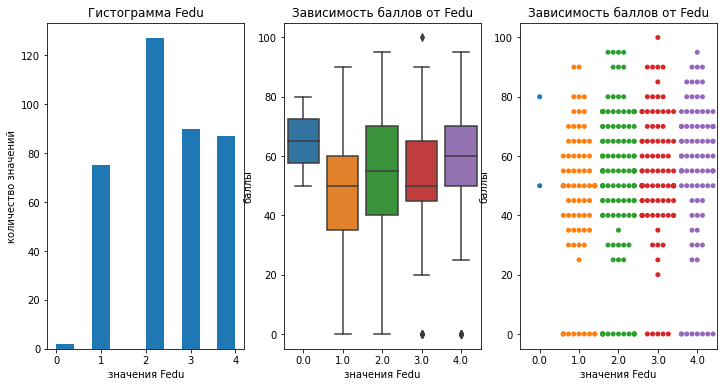

In [68]:
graf_cat('Fedu')

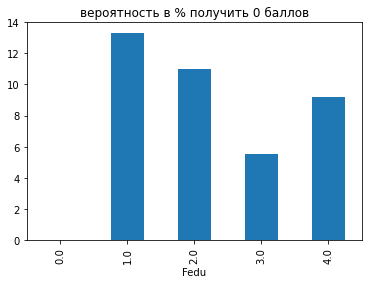

In [69]:
graf_no('Fedu')

Количество наблюдений для 0.0 всего 2. Судя по отображению, баллы и вероятность получить 0 баллов не зависят от образования отца

# работа родителей 
   #### 'teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое

### Mjob - матери
### Fjob - отца

In [70]:
categorial_view('Mjob')

В колонке уникальных значений: 5
В колонке пропущнных значений: 19
count       362
unique        5
top       other
freq        123
Name: Mjob, dtype: object
Распределение значений в %:
              Mjob
other     0.339779
services  0.262431
at_home   0.160221
teacher   0.149171
health    0.088398
Средние значения баллов по значениям:
Mjob
at_home     54.081633
health      64.666667
other       54.909910
services    59.482759
teacher     59.900000
Name: score, dtype: float64


In [71]:
stud_math[stud_math.Mjob.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
29,GP,M,16,U,GT3,T,4.0,4.0,NaN,teacher,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,4.0,4.0,5.0,5.0,16.0,55.0,YES
54,GP,F,15,U,LE3,T,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0,YES
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0,YES
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0,YES
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0,YES
128,GP,M,18,R,GT3,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0,NO
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0,YES
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0,YES
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0,YES
174,GP,F,16,U,LE3,T,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0,YES


Заменим на моду, так как не обнаружно связи с другими критериями:

In [72]:
replace_mode('Mjob')

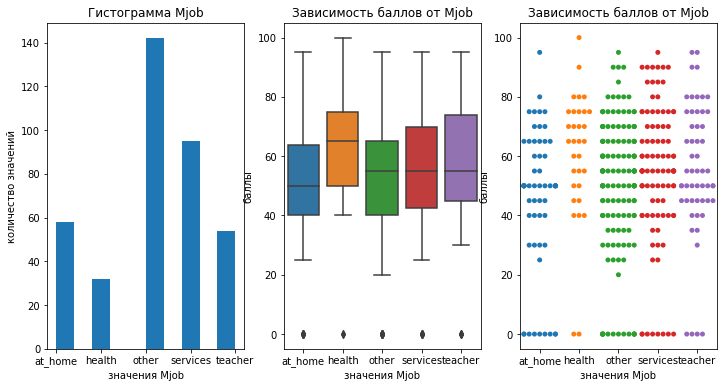

In [73]:
graf_cat('Mjob')

In [74]:
stud_math.groupby('Mjob').interest.value_counts(1)

Mjob      interest
at_home   YES         0.844828
          NO          0.155172
health    YES         0.937500
          NO          0.062500
other     YES         0.901408
          NO          0.098592
services  YES         0.915789
          NO          0.084211
teacher   YES         0.925926
          NO          0.074074
Name: interest, dtype: float64

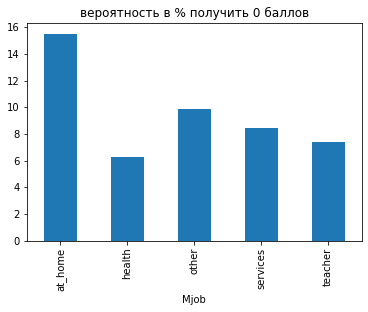

In [75]:
graf_no('Mjob')

Можно только отметить что у метерей, работающих в сфере здравоохранения балл немного выше за счет повышения нижней границы. И вероятность получить ноль выше всего у тех, чья мама сидит дома.

In [76]:
categorial_view('Fjob')

В колонке уникальных значений: 5
В колонке пропущнных значений: 36
count       345
unique        5
top       other
freq        191
Name: Fjob, dtype: object
Распределение значений в %:
              Fjob
other     0.553623
services  0.275362
teacher   0.081159
at_home   0.046377
health    0.043478
Средние значения баллов по значениям:
Fjob
at_home     59.285714
health      55.666667
other       56.763006
services    56.588235
teacher     66.000000
Name: score, dtype: float64


In [77]:
stud_math[stud_math.Fjob.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,YES
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0,YES
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0,YES
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0,YES
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0,YES
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0,YES
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0,YES
52,GP,M,15,U,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0,YES
59,GP,F,16,U,GT3,T,4.0,2.0,other,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0,YES
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0,YES


Аналогично заменим на моду, не выявив тенденций:

In [78]:
replace_mode('Fjob')

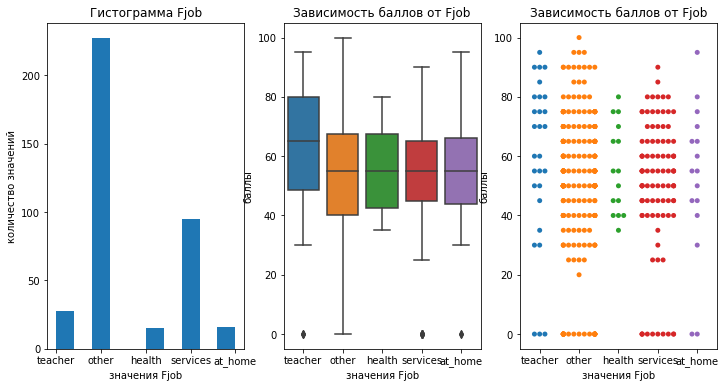

In [79]:
graf_cat('Fjob')

In [80]:
stud_math.groupby('Fjob').interest.value_counts(1)

Fjob      interest
at_home   YES         0.875000
          NO          0.125000
health    YES         1.000000
other     YES         0.903084
          NO          0.096916
services  YES         0.894737
          NO          0.105263
teacher   YES         0.892857
          NO          0.107143
Name: interest, dtype: float64

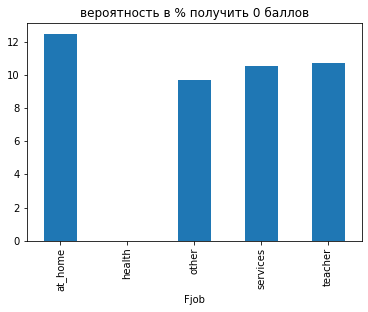

In [81]:
graf_no('Fjob')

Мало наблюдений для отцрв, работающих в сфере здравоохранения, учителей и безработных. Возможно поэтому вероятность получить 0 для сферы здравоохранения равно нулю. Набранные баллы отличаются слабо.

# reason

#### причина выбора школы
    'home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое

In [82]:
categorial_view('reason')

В колонке уникальных значений: 4
В колонке пропущнных значений: 17
count        364
unique         4
top       course
freq         134
Name: reason, dtype: object
Распределение значений в %:
              reason
course      0.368132
home        0.271978
reputation  0.269231
other       0.090659
Средние значения баллов по значениям:
reason
course        56.610169
home          58.275862
other         56.718750
reputation    59.565217
Name: score, dtype: float64


In [83]:
stud_math[stud_math.reason.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0,YES
63,GP,F,16,U,GT3,T,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0,YES
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0,YES
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0,YES
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0,YES
137,GP,F,16,U,GT3,A,3.0,2.0,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0,NO
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0,YES
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0,NO
185,GP,M,17,U,GT3,T,3.0,3.0,services,services,NaN,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,yes,4.0,3.0,4.0,4.0,12.0,55.0,YES
186,GP,M,16,U,GT3,T,1.0,2.0,services,services,NaN,mother,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,3.0,3.0,3.0,2.0,55.0,YES


Аналогично заменим на моду:

In [84]:
replace_mode('reason')

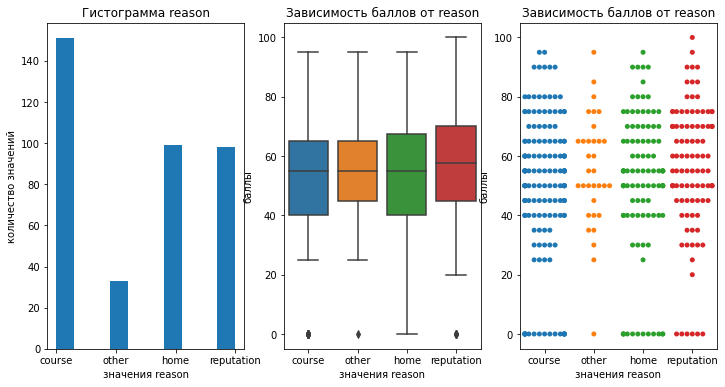

In [85]:
graf_cat('reason')

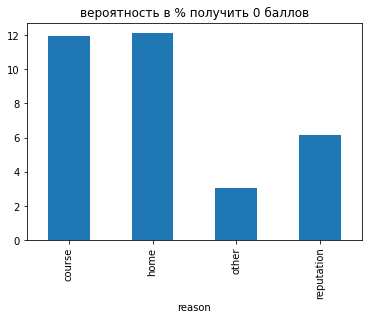

In [86]:
graf_no('reason')

Ни по средним баллам, ни по вероятности получить 0 нельзя отметить каких-то особенностей

# guardian

   ### опекун 
    'mother' - мать, 'father' - отец, 'other' - другое

In [87]:
categorial_view('guardian')

В колонке уникальных значений: 3
В колонке пропущнных значений: 30
count        351
unique         3
top       mother
freq         244
Name: guardian, dtype: object
Распределение значений в %:
        guardian
mother  0.695157
father  0.242165
other   0.062678
Средние значения баллов по значениям:
guardian
father    58.896104
mother    58.009050
other     55.555556
Name: score, dtype: float64


In [88]:
stud_math[stud_math.guardian.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,course,NaN,1.0,3.0,0.0,yes,NaN,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0,YES
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,home,NaN,1.0,1.0,0.0,no,yes,no,no,no,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0,YES
49,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,other,NaN,1.0,2.0,1.0,yes,yes,no,yes,no,yes,yes,no,4.0,4.0,4.0,3.0,2.0,35.0,YES
53,GP,F,15,U,GT3,T,4.0,4.0,services,services,course,NaN,1.0,1.0,0.0,yes,yes,yes,no,yes,yes,yes,no,3.0,3.0,4.0,5.0,0.0,55.0,YES
60,GP,F,16,R,GT3,T,4.0,4.0,health,teacher,other,NaN,1.0,2.0,0.0,no,yes,no,yes,yes,yes,no,no,2.0,4.0,4.0,4.0,6.0,55.0,YES
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0,YES
90,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,yes,yes,yes,4.0,3.0,3.0,4.0,0.0,40.0,YES
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0,YES
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,course,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0,YES
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0,NO


аналогично заменим на моду:

In [89]:
replace_mode('guardian')

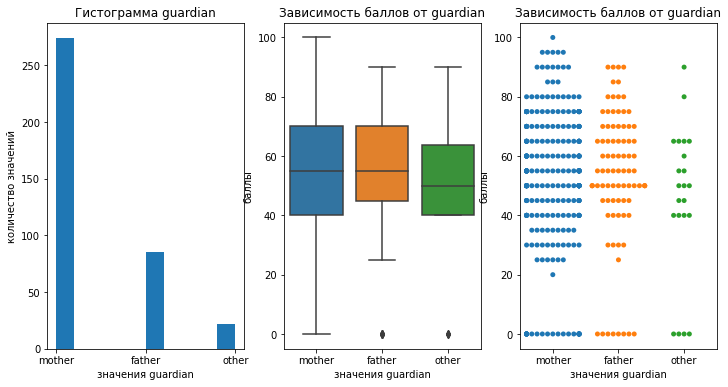

In [90]:
graf_cat('guardian')

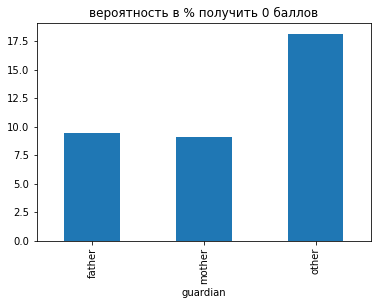

In [91]:
graf_no('guardian')

По средним баллам нельзя отметить каких-то особенностей. Вероятность получить 0 баллов выше в 2 раза, если указано 'другое'

# traveltime 

 ### время в пути до школы 
    1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.

In [92]:
categorial_view('traveltime')

В колонке уникальных значений: 4
В колонке пропущнных значений: 28
count    353.000000
mean       1.433428
std        0.692257
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64
Распределение значений в %:
     traveltime
1.0    0.662890
2.0    0.260623
3.0    0.056657
4.0    0.019830
Средние значения баллов по значениям:
traveltime
1.0    58.528037
2.0    56.904762
3.0    57.187500
4.0    50.000000
Name: score, dtype: float64


Аналогично address заменим на моду:

In [93]:
replace_mode('traveltime')

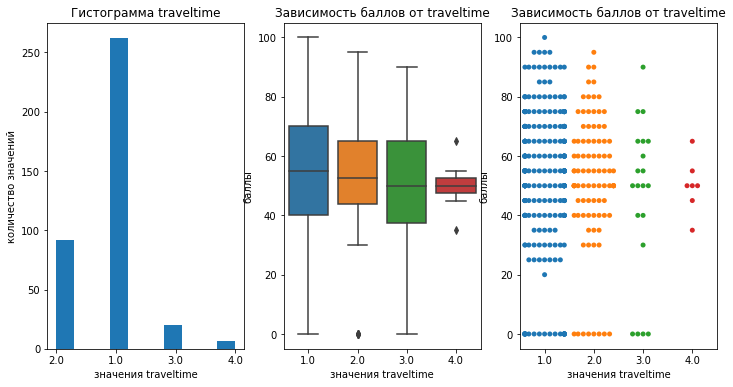

In [94]:
graf_cat('traveltime')

In [95]:
stud_math.groupby('traveltime').interest.value_counts(1)

traveltime  interest
1.0         YES         0.904580
            NO          0.095420
2.0         YES         0.913043
            NO          0.086957
3.0         YES         0.800000
            NO          0.200000
4.0         YES         1.000000
Name: interest, dtype: float64

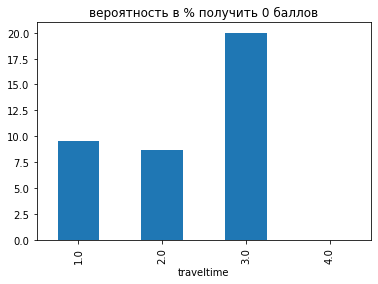

In [96]:
graf_no('traveltime')

С увеличением времени уменьшается количество наблюдений. Вероятно с этим связано что вероятность получить ноль баллов в 2 раза выше для параметра 3 и отсутствует для параметра 4. Зависимости в средних баллах слабая, но можно отметить уменьшение максимально набранных с увеличением времени до школы.

# studytime
### время на учёбу помимо школы в неделю 
    1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов

In [97]:
categorial_view('studytime')

В колонке уникальных значений: 4
В колонке пропущнных значений: 7
count    374.000000
mean       2.034759
std        0.851663
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64
Распределение значений в %:
     studytime
2.0   0.491979
1.0   0.272727
3.0   0.163102
4.0   0.072193
Средние значения баллов по значениям:
studytime
1.0    56.797753
2.0    55.565476
3.0    62.946429
4.0    63.333333
Name: score, dtype: float64


Аналогично заменим на моду:

In [98]:
replace_mode('studytime')

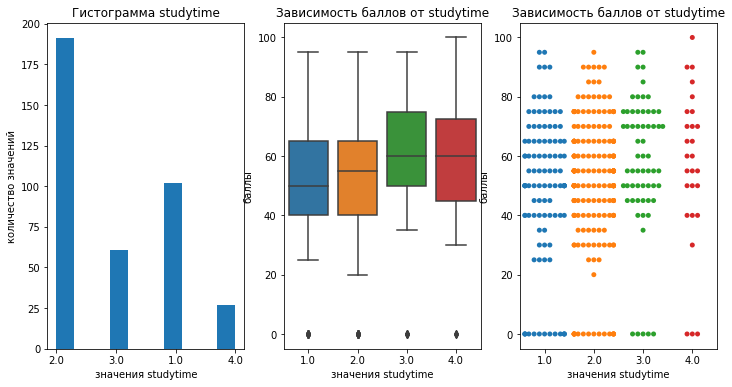

In [99]:
graf_cat('studytime')

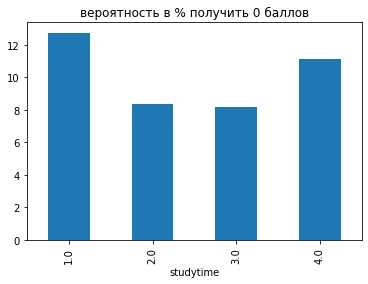

In [100]:
graf_no('studytime')

Корреляции между результатом в ноль баллов и временем на учебу нет. Но при увеличении времени с параметров 1-2 на 3-4 повышается нижняя граница, что повышает среднее значение

 # failures
### количество внеучебных неудач 
    n, если 1<=n<=3, иначе 0

In [101]:
categorial_view('failures')

В колонке уникальных значений: 4
В колонке пропущнных значений: 22
count    359.000000
mean       0.323120
std        0.729502
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64
Распределение значений в %:
     failures
0.0  0.793872
1.0  0.128134
2.0  0.038997
3.0  0.038997
Средние значения баллов по значениям:
failures
0.0    59.589552
1.0    50.694444
2.0    44.000000
3.0    41.500000
Name: score, dtype: float64


In [102]:
stud_math[stud_math.failures.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
21,GP,M,15,U,GT3,T,4.0,2.0,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0,YES
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0,YES
54,GP,F,15,U,LE3,T,3.0,3.0,other,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0,YES
68,GP,F,15,R,LE3,T,2.0,2.0,health,other,reputation,mother,1.0,2.0,NaN,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0,YES
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,NaN,no,no,yes,yes,yes,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0,YES
107,GP,M,16,U,GT3,T,3.0,3.0,services,other,home,father,1.0,3.0,NaN,no,yes,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,2.0,90.0,YES
108,GP,M,15,R,GT3,T,4.0,4.0,other,other,home,father,4.0,4.0,NaN,no,yes,yes,yes,yes,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0,YES
114,GP,M,15,R,GT3,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0,YES
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,NaN,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0,YES
125,GP,M,15,U,GT3,T,3.0,4.0,services,services,home,father,1.0,1.0,NaN,yes,no,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,0.0,60.0,YES


Аналогично заменим на моду:

In [103]:
replace_mode('failures')

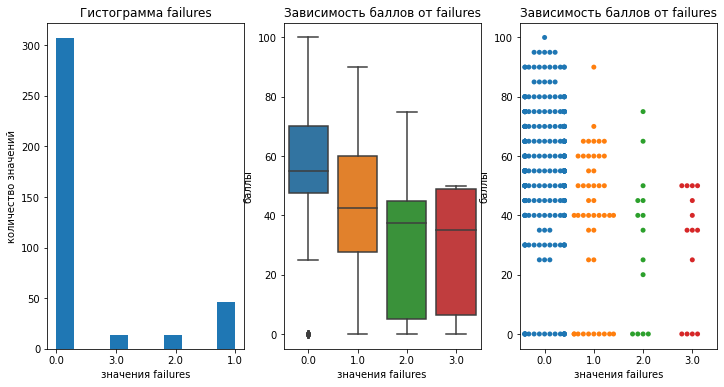

In [104]:
graf_cat('failures')

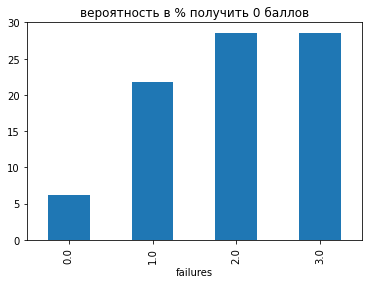

In [105]:
graf_no('failures')

лучшие результаты у параметра 0: и баллы и минимальный процент школьников с 0 баллами. Тогда как увеличение  n ухудшает результаты

# образовательная поддержка 
    yes или no

### schoolsup — дополнительная
### famsup — семейная
### paid — дополнительные платные занятия по математике

In [106]:
categorial_view('schoolsup')

В колонке уникальных значений: 2
В колонке пропущнных значений: 9
count     372
unique      2
top        no
freq      325
Name: schoolsup, dtype: object
Распределение значений в %:
     schoolsup
no    0.873656
yes   0.126344
Средние значения баллов по значениям:
schoolsup
no     59.861592
yes    47.065217
Name: score, dtype: float64


Заменим на моду:

In [107]:
replace_mode('schoolsup')

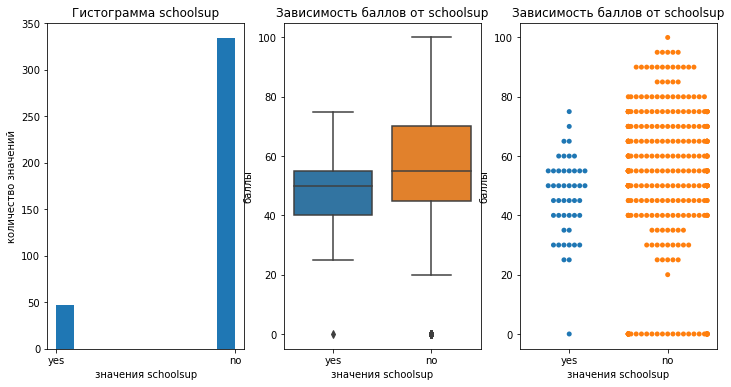

In [108]:
graf_cat('schoolsup')

In [109]:
stud_math.groupby('schoolsup').interest.value_counts(1)

schoolsup  interest
no         YES         0.892216
           NO          0.107784
yes        YES         0.978723
           NO          0.021277
Name: interest, dtype: float64

Наличие дополнительной поддержки и повышает баллы и понижает вероятность получить 0 баллов

In [110]:
categorial_view('famsup')

В колонке уникальных значений: 2
В колонке пропущнных значений: 36
count     345
unique      2
top       yes
freq      211
Name: famsup, dtype: object
Распределение значений в %:
       famsup
yes  0.611594
no   0.388406
Средние значения баллов по значениям:
famsup
no     58.613445
yes    57.225131
Name: score, dtype: float64


In [111]:
replace_mode('famsup')

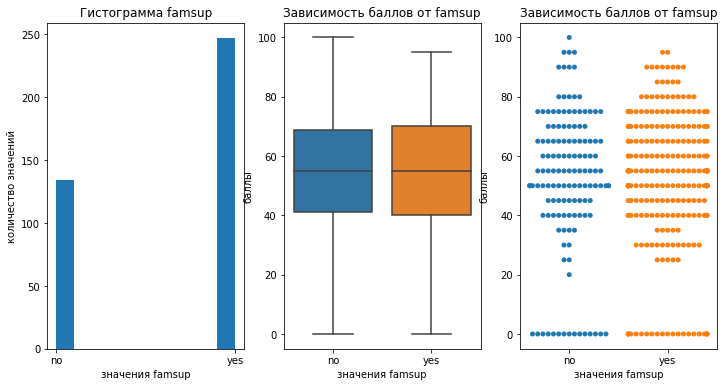

In [112]:
graf_cat('famsup')

In [113]:
stud_math.groupby('famsup').interest.value_counts(1)

famsup  interest
no      YES         0.888060
        NO          0.111940
yes     YES         0.910931
        NO          0.089069
Name: interest, dtype: float64

Наличие или отсутствие семейной поддержки на результаты школьников не влияют

In [114]:
categorial_view('paid')

В колонке уникальных значений: 2
В колонке пропущнных значений: 39
count     342
unique      2
top        no
freq      192
Name: paid, dtype: object
Распределение значений в %:
         paid
no   0.561404
yes  0.438596
Средние значения баллов по значениям:
paid
no     58.393939
yes    57.867133
Name: score, dtype: float64


In [115]:
replace_mode('paid')

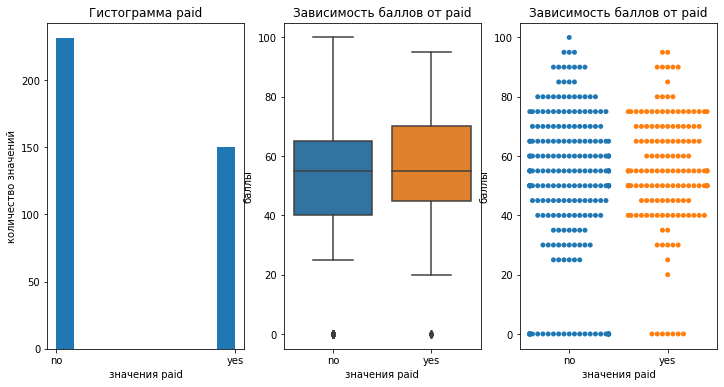

In [116]:
graf_cat('paid')

In [117]:
stud_math.groupby('paid').interest.value_counts(1)

paid  interest
no    YES         0.870130
      NO          0.129870
yes   YES         0.953333
      NO          0.046667
Name: interest, dtype: float64

Наличие платных курсов при обучении чуть уменьшают % получить 0 на экзамене и незначительно повышают среднее

 # activities
 ### дополнительные внеучебные занятия 
     yes или no

In [118]:
categorial_view('activities')

В колонке уникальных значений: 2
В колонке пропущнных значений: 14
count     367
unique      2
top       yes
freq      189
Name: activities, dtype: object
Распределение значений в %:
     activities
yes    0.514986
no     0.485014
Средние значения баллов по значениям:
activities
no     56.932515
yes    58.934911
Name: score, dtype: float64


In [119]:
replace_mode('activities')

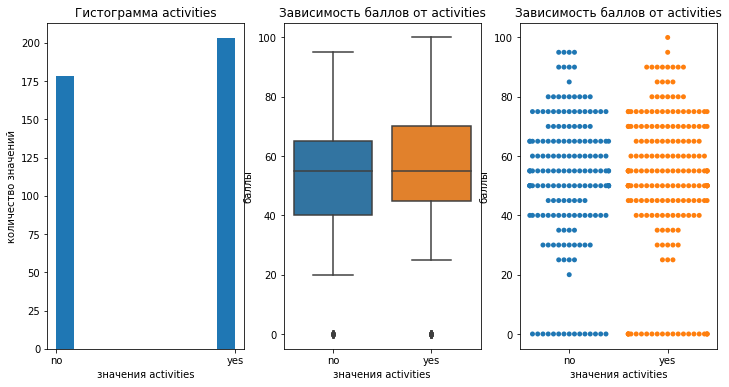

In [120]:
graf_cat('activities')

In [121]:
stud_math.groupby('activities').interest.value_counts(1)

activities  interest
no          YES         0.915730
            NO          0.084270
yes         YES         0.891626
            NO          0.108374
Name: interest, dtype: float64

Наличие дополнитльных занятий н оказывают заметного эффекта

# nursery
### посещал детский сад 
    yes или no

In [122]:
categorial_view('nursery')

В колонке уникальных значений: 2
В колонке пропущнных значений: 15
count     366
unique      2
top       yes
freq      290
Name: nursery, dtype: object
Распределение значений в %:
     nursery
yes  0.79235
no   0.20765
Средние значения баллов по значениям:
nursery
no     56.791045
yes    57.924528
Name: score, dtype: float64


Заменим пропущенные значения на моду

In [123]:
replace_mode('nursery')

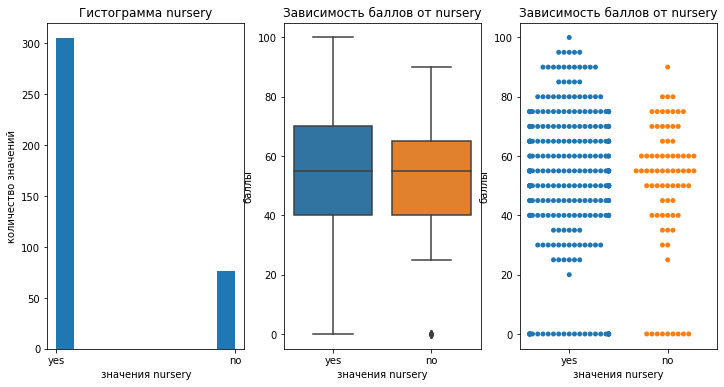

In [124]:
graf_cat('nursery')

In [125]:
stud_math.groupby('nursery').interest.value_counts(1)

nursery  interest
no       YES         0.881579
         NO          0.118421
yes      YES         0.908197
         NO          0.091803
Name: interest, dtype: float64

Заметных отличий при посещении детского сада не наблюдается

# higher
### хочет получить высшее образование 
    yes или no

In [126]:
categorial_view('higher')

В колонке уникальных значений: 2
В колонке пропущнных значений: 20
count     361
unique      2
top       yes
freq      343
Name: higher, dtype: object
Распределение значений в %:
       higher
yes  0.950139
no   0.049861
Средние значения баллов по значениям:
higher
no     49.583333
yes    58.162939
Name: score, dtype: float64


Замним на моду:

In [127]:
replace_mode('higher')

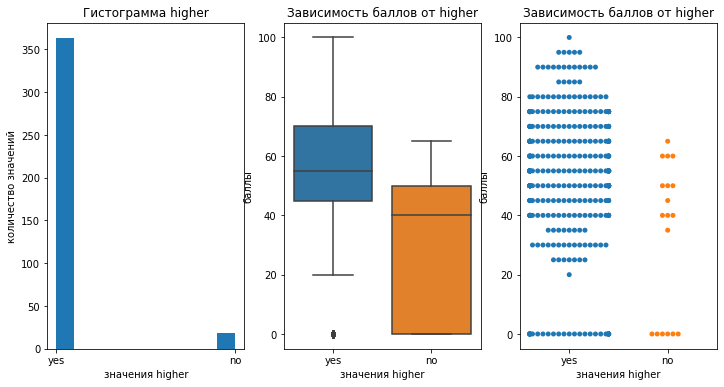

In [128]:
graf_cat('higher')

In [129]:
stud_math.groupby('higher').interest.value_counts(1)

higher  interest
no      YES         0.666667
        NO          0.333333
yes     YES         0.914601
        NO          0.085399
Name: interest, dtype: float64

Нежелание получить высшее образование заметно сказывается на результатах: существенно ниже балл и заметно выше вероятность получить 0 баллов.

# internet
### наличие интернета дома 
    yes или no

In [130]:
categorial_view('internet')

В колонке уникальных значений: 2
В колонке пропущнных значений: 34
count     347
unique      2
top       yes
freq      293
Name: internet, dtype: object
Распределение значений в %:
     internet
yes   0.84438
no    0.15562
Средние значения баллов по значениям:
internet
no     55.312500
yes    58.258427
Name: score, dtype: float64


In [131]:
stud_math.groupby('address').internet.value_counts(1)

address  internet
R        yes         0.693333
         no          0.306667
U        yes         0.886029
         no          0.113971
Name: internet, dtype: float64

Наблюдается взаимосвязь места проживания и наличия интернета. Посмотрим на пропуски:

In [132]:
stud_math[stud_math.internet.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,interest
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,YES
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0,YES
52,GP,M,15,U,LE3,A,4.0,2.0,health,other,other,father,2.0,1.0,1.0,no,yes,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0,YES
65,GP,F,16,U,LE3,T,4.0,3.0,teacher,services,course,mother,3.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,3.0,1.0,2.0,75.0,YES
80,GP,M,15,U,GT3,T,2.0,3.0,other,services,course,father,1.0,1.0,0.0,yes,yes,yes,yes,no,yes,NaN,yes,3.0,2.0,2.0,3.0,2.0,60.0,YES
86,GP,F,16,U,LE3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,NaN,no,4.0,3.0,4.0,2.0,4.0,30.0,YES
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0,YES
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0,YES
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0,YES
117,GP,M,16,U,GT3,T,3.0,3.0,other,services,home,father,2.0,1.0,0.0,no,no,no,yes,yes,yes,NaN,no,5.0,4.0,2.0,5.0,0.0,65.0,YES


Для города чаще интернет есть, заменим на моду:

In [133]:
replace_mode('internet')

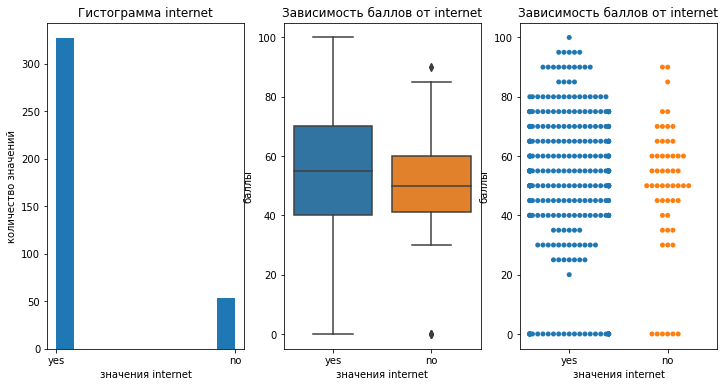

In [134]:
graf_cat('internet')

In [135]:
stud_math.groupby('internet').interest.value_counts(1)

internet  interest
no        YES         0.888889
          NO          0.111111
yes       YES         0.905199
          NO          0.094801
Name: interest, dtype: float64

Вероятность получить 0 баллов практичски не зависит от интернета, как и средний балл. Но диапазон баллов для тех, у кого нет интернета уже: ограничение и по верхней и по нижней границе

 # romantic  
### в романтических отношениях 
    yes или no

In [136]:
categorial_view('romantic')

В колонке уникальных значений: 2
В колонке пропущнных значений: 31
count     350
unique      2
top        no
freq      231
Name: romantic, dtype: object
Распределение значений в %:
     romantic
no       0.66
yes      0.34
Средние значения баллов по значениям:
romantic
no     58.511628
yes    56.850000
Name: score, dtype: float64


Заменим на моду:

In [137]:
replace_mode('romantic')

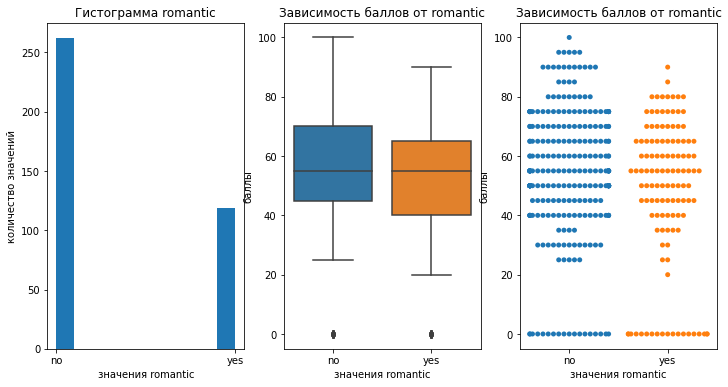

In [138]:
graf_cat('romantic')

In [139]:
stud_math.groupby('romantic').interest.value_counts(1)

romantic  interest
no        YES         0.931298
          NO          0.068702
yes       YES         0.840336
          NO          0.159664
Name: interest, dtype: float64

Те школьники, которые состоят в отношениях получили ниже баллы и чаще получили 0 баллов. 

# famrel 
### семейные отношения 
    от 1 - очень плохо до 5 - очень хорошо

In [140]:
categorial_view('famrel')

В колонке уникальных значений: 6
В колонке пропущнных значений: 26
count    355.000000
mean       3.926761
std        0.929880
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64
Распределение значений в %:
        famrel
 4.0  0.492958
 5.0  0.264789
 3.0  0.174648
 2.0  0.045070
 1.0  0.019718
-1.0  0.002817
Средние значения баллов по значениям:
famrel
-1.0    40.000000
 1.0    64.166667
 2.0    56.923077
 3.0    56.964286
 4.0    56.437500
 5.0    60.941176
Name: score, dtype: float64


Заменим на моду и уберем значение -1, которое является выбросом

In [141]:
replace_mode('famrel')
stud_math.famrel = stud_math.famrel.astype(float)
stud_math = stud_math.loc[stud_math.famrel.between(1, 5)]

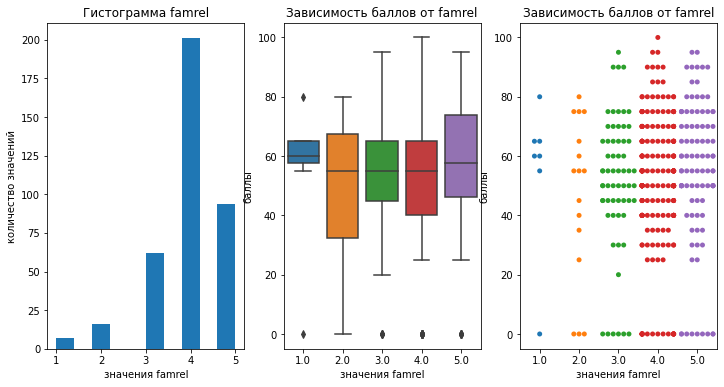

In [142]:
graf_cat('famrel')

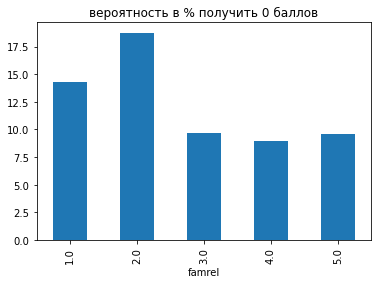

In [143]:
graf_no('famrel')

Для значений 3-5 данные идентичны, а для 1 - 2 мало наблюдений, что в целом не дает понять влияние на баллы. Но повышает вероятность получить 0 баллов.

#  freetime
### свободное время после школы 
    от 1 - очень мало до 5 - очень мого

In [144]:
categorial_view('freetime')

В колонке уникальных значений: 5
В колонке пропущнных значений: 8
count    372.000000
mean       3.239247
std        0.981921
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64
Распределение значений в %:
     freetime
3.0  0.400538
4.0  0.295699
2.0  0.163978
5.0  0.096774
1.0  0.043011
Средние значения баллов по значениям:
freetime
1.0    55.000000
2.0    61.842105
3.0    56.395349
4.0    56.764706
5.0    60.000000
Name: score, dtype: float64


In [145]:
replace_mode('freetime')

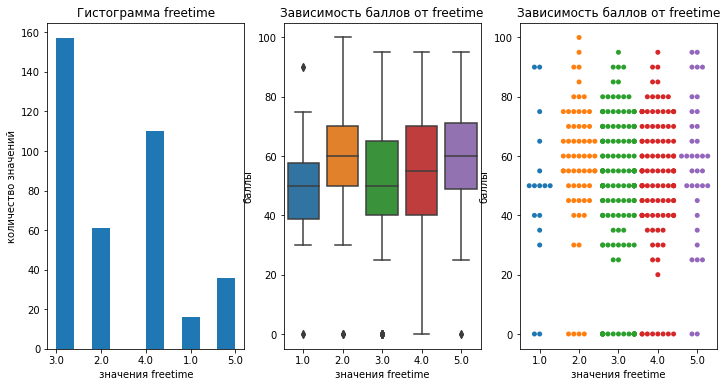

In [146]:
graf_cat('freetime')

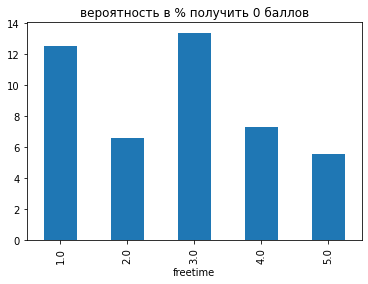

In [147]:
graf_no('freetime')

Мало наблюдений для школьников, у которых очень мало времени после школы, однако можно предполжить что данные баллов в том же диапазоне. для остальных влияния на баллы практически нет. Дя значений 1 и 3 вероятность в 2 раза выш чем у других. 

# goout
### проведение времени с друзьями 
    от 1 - очень мало до 5 - очень много

In [148]:
categorial_view('goout')

В колонке уникальных значений: 5
В колонке пропущнных значений: 7
count    373.000000
mean       3.109920
std        1.112603
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64
Распределение значений в %:
        goout
3.0  0.332440
2.0  0.262735
4.0  0.211796
5.0  0.136729
1.0  0.056300
Средние значения баллов по значениям:
goout
1.0    59.117647
2.0    61.797753
3.0    59.094828
4.0    54.513889
5.0    52.790698
Name: score, dtype: float64


In [149]:
replace_mode('goout')

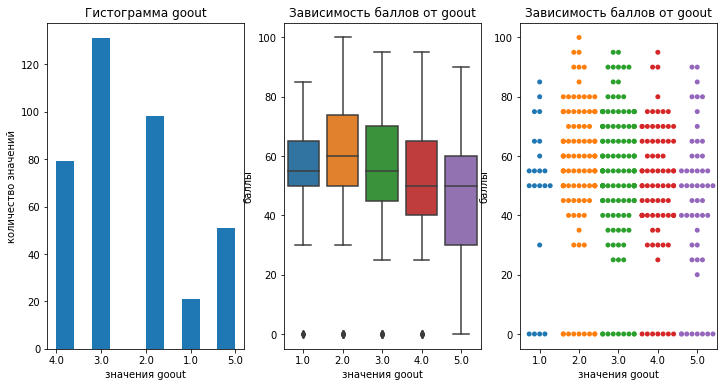

In [150]:
graf_cat('goout')

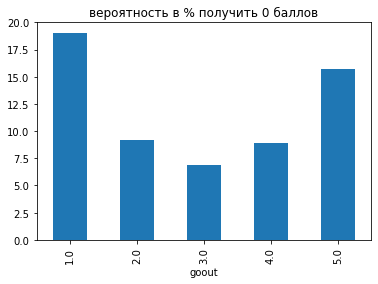

In [151]:
graf_no('goout')

Значение 1 представлено малым количеством данных, что делает спорным анализ этого значения с учетом того, что дальнейшнее увеличение времени приводит к снижению набранных баллов  

# health
### текущее состояние здоровья 
    от 1 - очень плохо до 5 - очень хорошо

In [152]:
categorial_view('health')

В колонке уникальных значений: 5
В колонке пропущнных значений: 15
count    365.000000
mean       3.523288
std        1.405496
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64
Распределение значений в %:
       health
5.0  0.367123
3.0  0.235616
4.0  0.156164
1.0  0.126027
2.0  0.115068
Средние значения баллов по значениям:
health
1.0    62.500000
2.0    61.388889
3.0    54.620253
4.0    58.100000
5.0    57.933884
Name: score, dtype: float64


In [153]:
replace_mode('health')

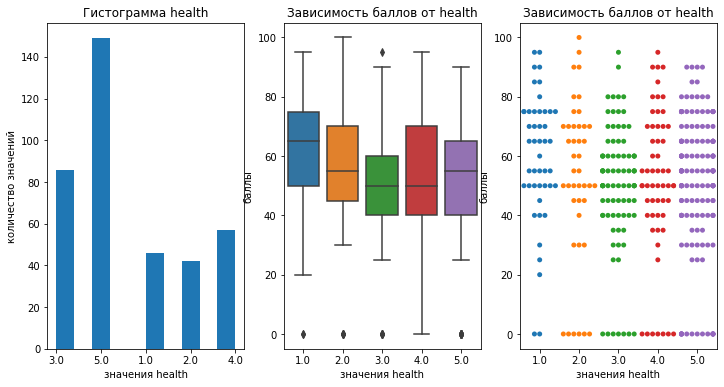

In [154]:
graf_cat('health')

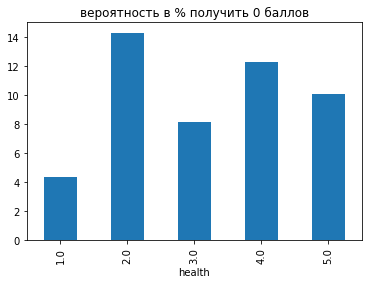

In [155]:
graf_no('health')

В целом здоровье не оказывает заметной разницы на баллы. Вероятность полуучить 0 баллов ниже всего для тех, у кого здоровье хуже всего. 

# Корреляционный анализ

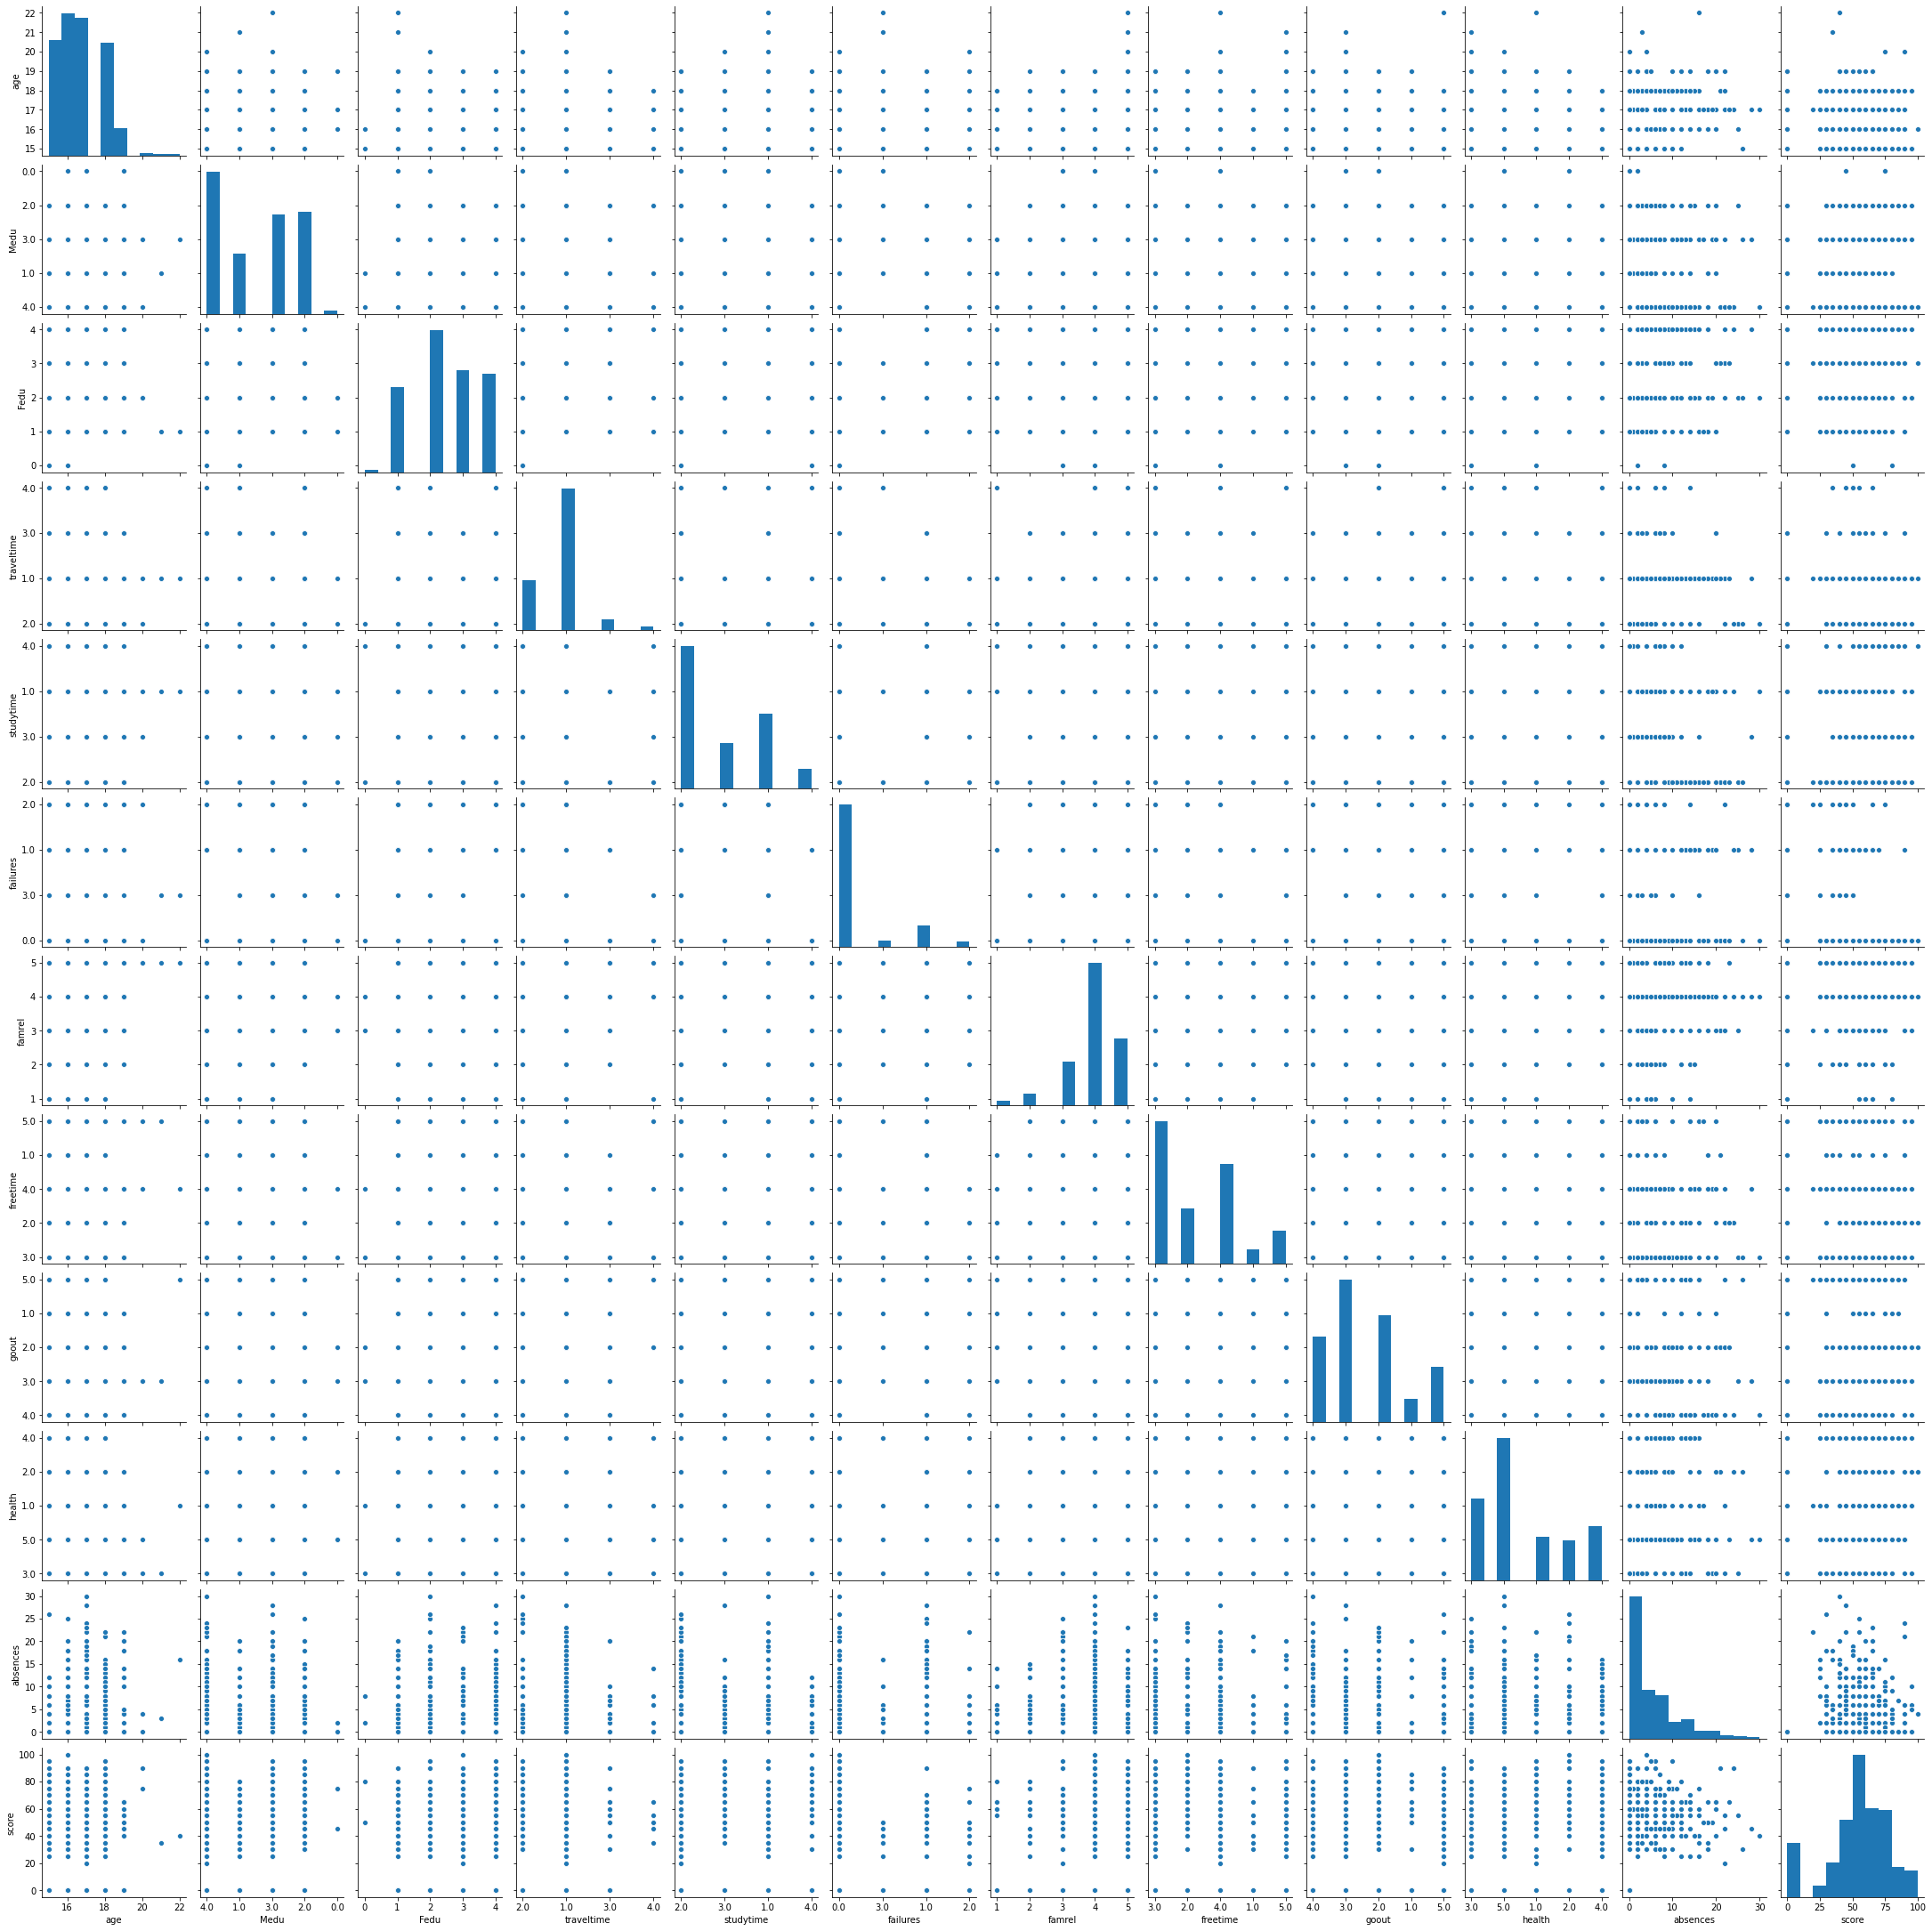

In [156]:
sns.pairplot(stud_math)

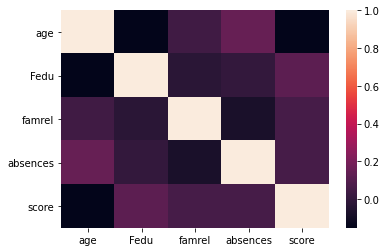

In [157]:
corr_matrix = stud_math.corr()
sns.heatmap(corr_matrix);

In [158]:
for col in binary_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [159]:
for col in categorial_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures


Если не проводить замену на моду, а провести анализ с учетом заполненных данных, то в категориальных данных будут статистически значимые колонки: Medu, failures, goout

stud_math = pd.read_csv('stud_math.csv')
for i in categorial_columns:
    stud_math.loc[:, i] = stud_math.loc[:, i].astype(
        str).apply(lambda x: None if x.strip() == '' else x)
stud_math.famrel = stud_math.famrel.astype(float)
stud_math = stud_math.loc[stud_math.famrel.between(1, 5)]
stud_math.Fedu = stud_math.Fedu.astype(float)
stud_math = stud_math.loc[stud_math.score.notnull()]
stud_math = stud_math.loc[stud_math.absences.between(0, 30)]
stud_math = stud_math.loc[stud_math.Fedu.between(0, 4)]
for col in categorial_columns:
    get_stat_dif(col)

'sex', 'Mjob', и 'Fedu', 'studytime'  не видно чтобы влияли заметно, поэтоиу их уберем.'age','address', 'romanic', 'goout' влияют, но слабо. Но оставим их. 'absences', 'schoolsup', 'paid', 'higher', 'Medu', 'failures' более значимо влияют. Плюс введеный критерий 'interest'

В результате EDA для анализа влияния параметров условий школьников на результаты баллов, полученных по математике были получены следующие выводы:
- В данных достаточно мало пропущенных значений, колонки age, sex и school были заполнены полностью;
- Выбросы найдены только в столбцах absences, Fedu и famrel, что позволяет сделать вывод о том, что данные достаточно чистые;
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это age, absences, address, schoolsup, paid, higher, romanic, Medu, failures, goout;
- дополнительно введен признак interest, по отношению к которому можно оценить можно оценить вроятность получить 0 баллов.

In [160]:
stud_math = stud_math.loc[:, ['age', 'absences', 'address', 'schoolsup', 'paid', 'higher', 'romanic', 'Medu', 'failures', 'goout', 'interest']]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'